### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [3]:
!pip install biopython
!pip install plotnine

**1.2 | Import Required Packages**

In [4]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [5]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            full_query = f"{query} AND ({year}[Date - Publication])"
            handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
            record = Entrez.read(handle)
            count = int(record["Count"])
            publication_counts[term].append(count)
            handle.close()

    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

search_terms = {
    "Long Covid Only": "(Long Covid) NOT (Cognitive Behavioural Therapy OR CBT OR Graded Exercise Therapy OR GET)",
    "Long Covid and CBT Only": "(Long Covid) AND (Cognitive Behavioural Therapy OR CBT) NOT (Graded Exercise Therapy OR GET)",
    "Long Covid and GET Only": "(Long Covid) AND (Graded Exercise Therapy OR GET) NOT (Cognitive Behavioural Therapy OR CBT)",
    "Long Covid and CBT and GET": "(Long Covid) AND (Cognitive Behavioural Therapy OR CBT) AND (Graded Exercise Therapy OR GET)"
}

start_year = 2019
end_year = 2023  # Assuming current year as end year

publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.head()

,Long Covid Only,Long Covid and CBT Only,Long Covid and GET Only,Long Covid and CBT and GET
Year,,,,
2019,0,0,0,0
2020,4063,12,30,0
2021,8976,36,87,1
2022,10556,35,103,2
2023,8424,51,90,3


In [7]:
# Convert the data to a long format
long_df = publications_df.reset_index().melt(id_vars='Year', var_name='Category', value_name='Count')

# Calculate the total publications per year for normalization
long_df['Total'] = long_df.groupby('Year')['Count'].transform('sum')

# Calculate the percentage of publications for each category per year
long_df['Percentage'] = 100 * long_df['Count'] / long_df['Total']

# Check result
long_df

,Year,Category,Count,Total,Percentage
0,2019,Long Covid Only,0,0,NaN
1,2020,Long Covid Only,4063,4105,98.976857
2,2021,Long Covid Only,8976,9100,98.637363
3,2022,Long Covid Only,10556,10696,98.691099
4,2023,Long Covid Only,8424,8568,98.319328
5,2019,Long Covid and CBT Only,0,0,NaN
6,2020,Long Covid and CBT Only,12,4105,0.292326
7,2021,Long Covid and CBT Only,36,9100,0.395604
8,2022,Long Covid and CBT Only,35,10696,0.327225
9,2023,Long Covid and CBT Only,51,8568,0.595238


### 📈  3 | Visualise Results
---

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 4 rows containing missing values.


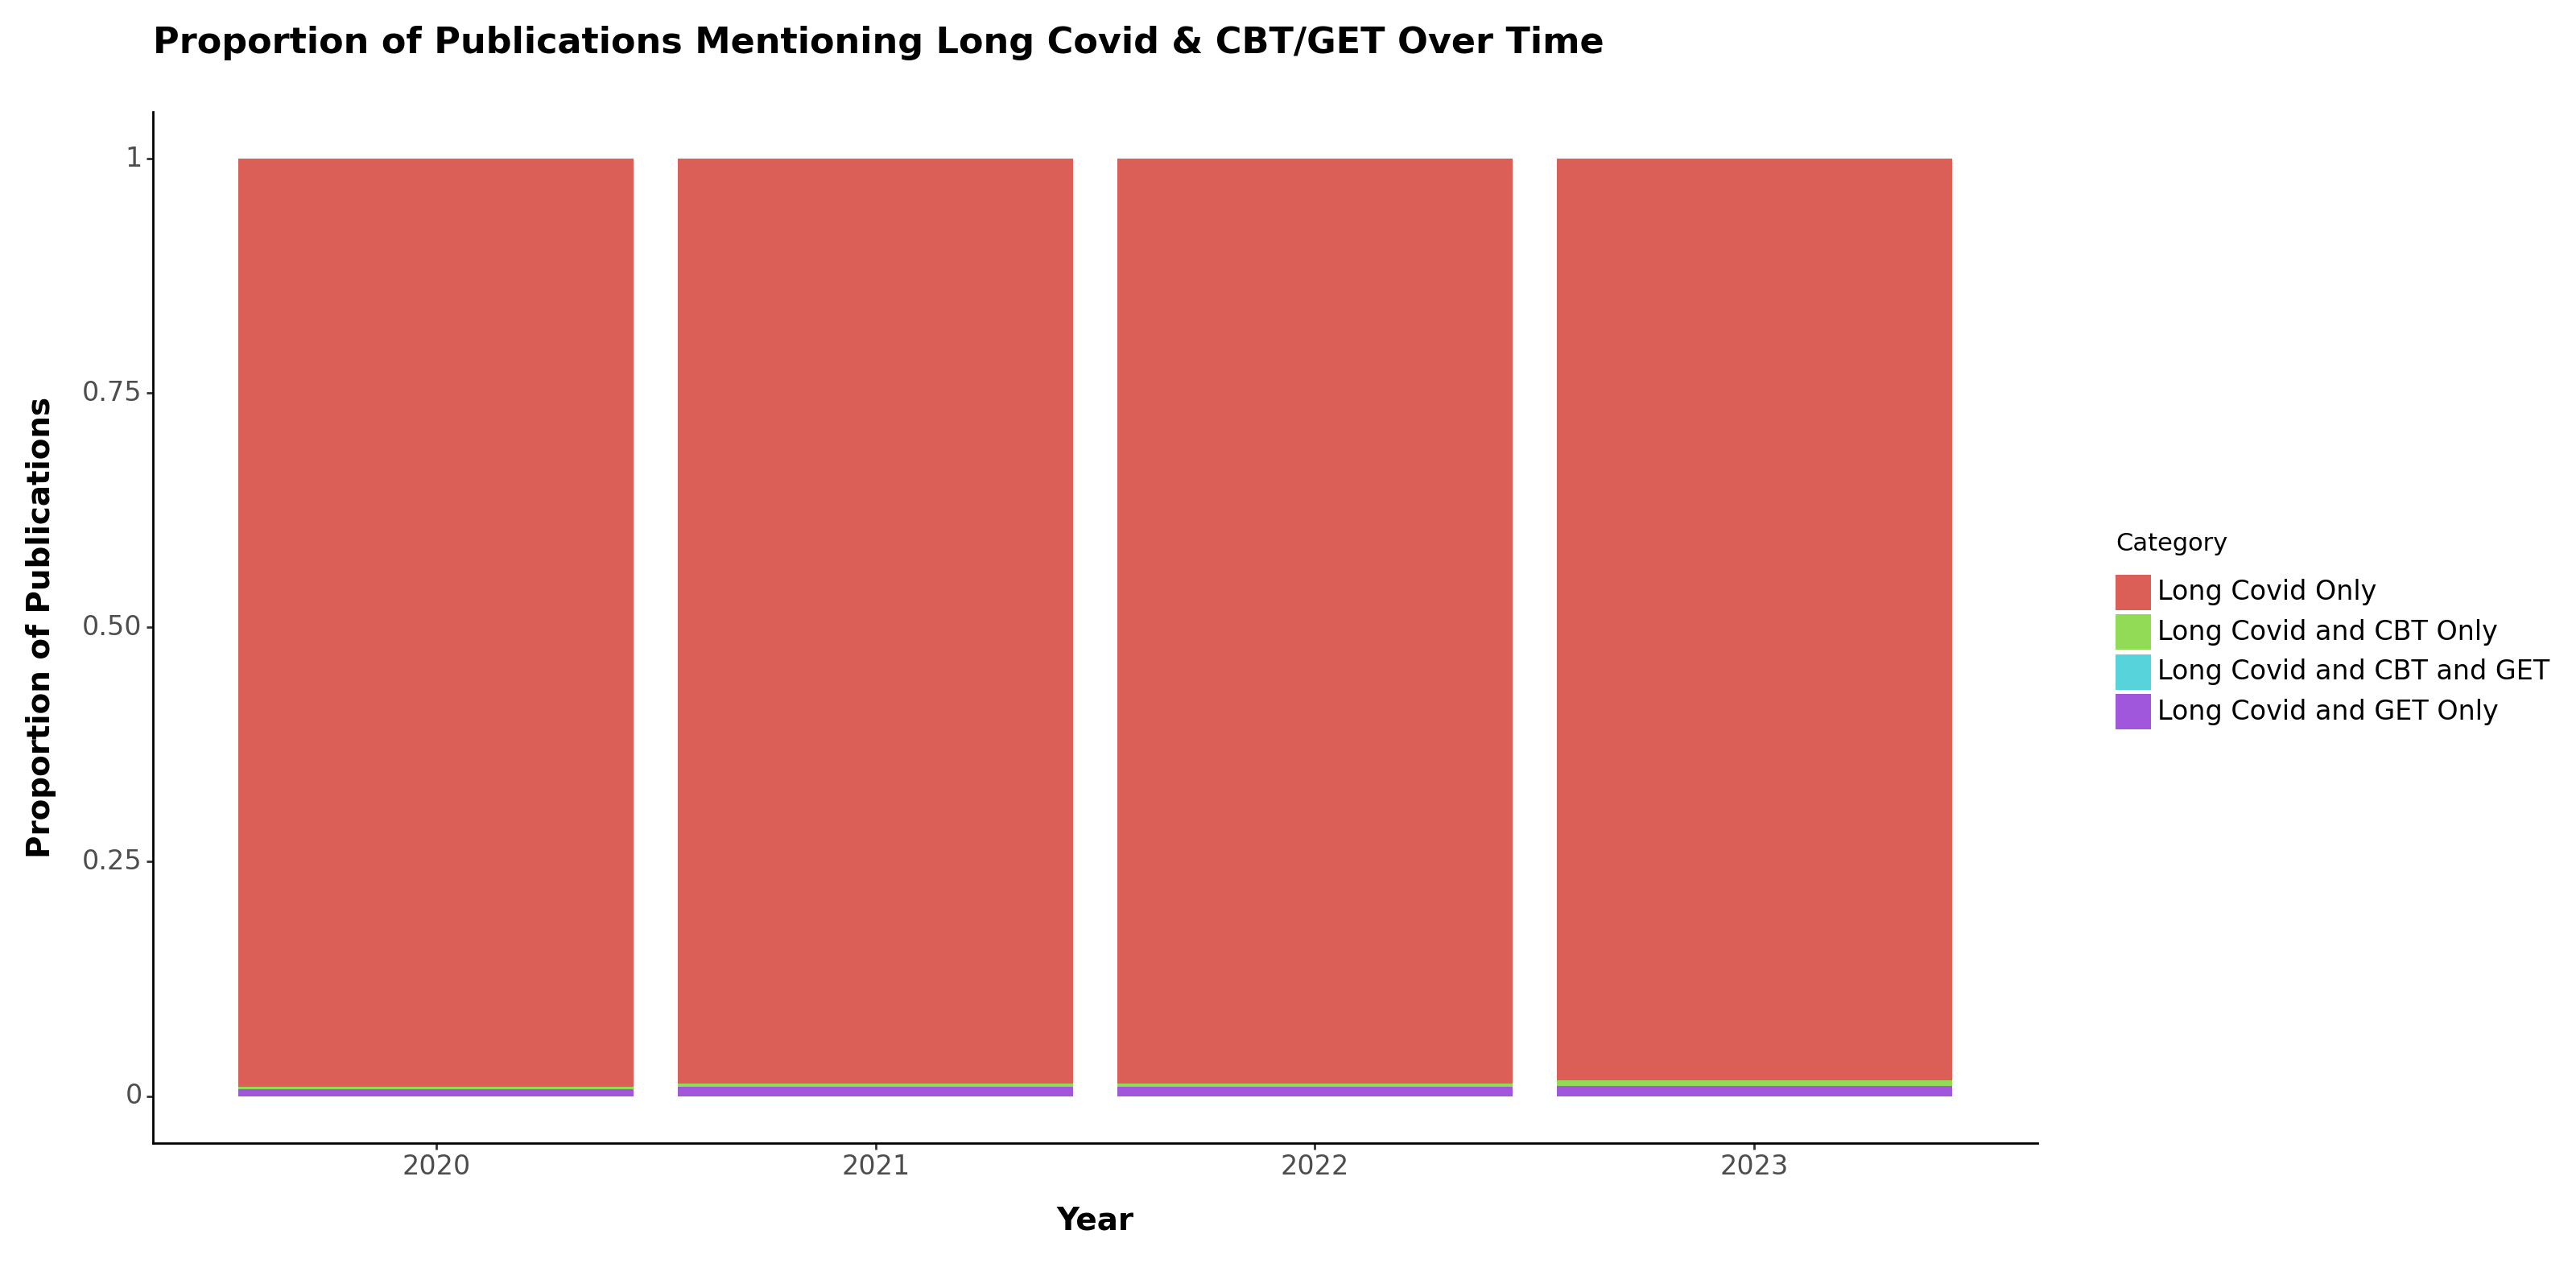

In [11]:
# Create a percentage stacked bar chart using plotnine
plot = (ggplot(long_df, aes(x='Year', y='Percentage', fill='Category'))
        + geom_bar(stat='identity', position='fill')  # Stacks percentage for each category
        + labs(x='Year', y='Proportion of Publications', fill='Category', title='Proportion of Publications Mentioning Long Covid & CBT/GET Over Time')
        + theme_classic()
        + theme(figure_size=(16, 8),
              axis_title=element_text(size=14, weight='bold'),
              axis_text=element_text(size=12),
              plot_title=element_text(size=16, weight='bold'),
              legend_text=element_text(size=12))
        )

# Display the plot
print(plot)